<a href="https://colab.research.google.com/github/Dynami/quantcon2018/blob/master/Quantcon-RL-Example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir appo_lib
%cd appo_lib

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz

%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

/content/appo_lib
--2020-04-02 12:28:24--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-04-02 12:28:29--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-04-02 12:28:30--  https://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc

In [10]:
#%cd ../..
!pwd
!ls -l

/content
total 25484
drwxr-xr-x 3 root root     4096 Apr  2 12:28 appo_lib
-rw-r--r-- 1 root root 26083553 Apr  2 12:33 data.txt
drwxr-xr-x 1 root root     4096 Mar 18 16:23 sample_data


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import talib
import traceback

%matplotlib inline

In [0]:
import requests
url = "https://github.com/Dynami/quantcon2018/blob/master/data.txt?raw=true"
r = requests.get(url)

f = open('data.txt', 'w')
f.write(r.content.decode("utf-8") )
f.close()

### Parse a data file into Pandas

In [11]:
dateparse = lambda x,y: pd.datetime.strptime(x+' '+y, '%m/%d/%Y %H:%M')
df = pd.read_csv('data.txt',parse_dates=[[0,1]],index_col=0,skiprows=0,date_parser=dateparse)
df.index.rename('Time',inplace=True)
df.columns = ['open','high','low','close','volume']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


### Plot the data

### Create a synthetic test series

Here we create a sine wave and a trend line. 
The parameter mult determines the amount of noise in our system

In [0]:
def create_synth_series(x,y,mult=1):    
    op = pd.Series(y+mult*np.random.randn(len(df)),index=df.index)
    cl = pd.Series(y+mult*np.random.randn(len(df)),index=df.index)
    hi = pd.Series(y+1+mult*np.abs(np.random.randn(len(df))),index=df.index)
    lo = pd.Series(y-1-mult*np.abs(np.random.randn(len(df))),index=df.index)
    dfs = pd.DataFrame([op,hi,lo,cl]).T
    dfs.index.rename('Time',inplace=True)
    dfs.columns = ['open','high','low','close']
    return dfs

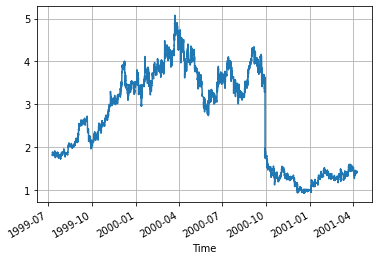

In [12]:
df = df.iloc[30000:70000]
df['close'].plot()
plt.grid()

In [0]:
ldf = len(df)
mid= int(ldf/2)
x = np.arange(len(df))
y = np.zeros(ldf)
y[mid:] = 0.01*x[:mid]+100
y[:mid] = 10*np.sin(0.01*x[:mid])+100#+y[mid-1]
dft = create_synth_series(x,y,mult=0.00)

In [0]:
dft['close'].plot()

### This is the Reinforcement Learning part of the system

In [0]:
class ExperienceReplay(object):
    '''This class gathers and delivers the experience'''
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

### Defining the "Trading Game"

Here we define our state, reward and policy.

In [0]:
class Game(object):
    '''This is the game. It starts, then takes an action (buy or sell) at some point and finally the reverse
    action, at which point it is game over. This is where the reward is given. The state consists of a vector
    with different bar sizes for OLHC. They are just concatenated. 
    lkbk: determines how many bars to use - larger lkbk - bigger state
    '''
    def __init__(self, df, lkbk=20, max_game_len=1000, run_mode='sequential', init_idx=None):
        self.df = df
        self.lkbk = lkbk
        self.max_game_len = max_game_len
        
        self.is_over = False
        self.reward = 0
        self.run_mode =  run_mode
        self.pnl_sum = 0
        if run_mode == 'sequential' and init_idx == None:
            print('------No init_idx set for "sequential": stopping------')
            return
        else:
            self.init_idx = init_idx
        self.reset()
        
    def _update_state(self, action):
        
        '''Here we update our state'''
        self.curr_idx += 1
        self.curr_time = self.df.index[self.curr_idx]
        self.curr_price = self.df['close'][self.curr_idx]
        self.pnl = (-self.entry + self.curr_price)*self.position/self.entry
        self._assemble_state()
        _k = list(map(float,str(self.curr_time.time()).split(':')[:2]))
        print('Game::_update_state() _k', _k)
        self._time_of_day = (_k[0]*60 + _k[1])/(24*60) 
        self._day_of_week  = self.curr_time.weekday()/6
        self.norm_epoch = (df.index[self.curr_idx]-df.index[0]).total_seconds()/self.t_in_secs
        
        '''This is where we define our policy and update our position'''
        if action == 0:  
            pass
        
        elif action == 2:
            if self.position == -1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx
   
            elif self.position == 0:
                self.position = 1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else: 
                pass
            
        elif action == 1:
            if self.position == 1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx

            elif self.position == 0:
                self.position = -1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else:
                pass
        
    
    def _assemble_state(self):
        '''Here we can add other things such as indicators and times'''
        self._get_last_N_timebars()
        bars = [self.last5m, self.last1h, self.last1d]
        state = []
        candles = {j:{k:np.array([]) for k in ['open','high','low','close']} for j in range(len(bars))}
        for j,bar in enumerate(bars):
            for col in ['open','high','low','close']:
                candles[j][col] = np.asarray(bar[col])
                state += (list(np.asarray(bar[col]))[-10:])

        
        self.state = np.array([])
        self.state = np.append(self.state, state)
        self.state = np.append(self.state, self.position)
        np.append(self.state, np.sign(self.pnl_sum))
        self.state = np.append(self.state, self._time_of_day)
        self.state = np.append(self.state, self._day_of_week)
        
        for c in candles:
            try:
                sma1 = talib.EMA(candles[c]['close'],self.lkbk-1)[-1]
                sma2 = talib.EMA(candles[c]['close'],self.lkbk-8)[-1]
                self.state = np.append(self.state,(sma1-sma2)/sma2)
                self.state = np.append(self.state,sma1)
                self.state = np.append(self.state,talib.RSI(candles[c]['close'],self.lkbk-1)[-1])
                self.state = np.append(self.state,talib.MOM(candles[c]['close'],self.lkbk-1)[-1])
                #self.state = np.append(self.state,talib.MACD(candles[c]['close'],fastperiod=11, slowperiod=22, signalperiod=9)[0][0])
                self.state = np.append(self.state,talib.BOP(candles[c]['open'],
                                               candles[c]['high'],
                                               candles[c]['low'],
                                               candles[c]['close'])[-1])
                #self.state = np.append(self.state,talib.ADXR(candles[c]['high'],
                #                               candles[c]['low'],
                #                               candles[c]['close'],
                #                               self.lkbk-3)[-1]) 
                #self.state = np.append(self.state,talib.STOCH(candles[c]['high'],
                #                               candles[c]['low'],
                #                               candles[c]['close'],5,3,0,3,0)[-1][0])
                self.state = np.append(self.state,talib.AROONOSC(candles[c]['high'],
                                               candles[c]['low'],
                                               self.lkbk-3)[-1])
            except: print(traceback.format_exc())
        #print('-->',self.state)
        self.state = (np.array(self.state)-np.mean(self.state))/np.std(self.state)
        


        
        
    def _get_last_N_timebars(self):
        '''The lengths of the time windows are currently hardcoded.'''
        # TODO: find better way to calculate window lengths
        wdw5m = 9
        wdw1h = np.ceil(self.lkbk*15/24.)
        wdw1d = np.ceil(self.lkbk*15)
        
        self.last5m = self.df[self.curr_time-timedelta(wdw5m):self.curr_time].iloc[-self.lkbk:]
        self.last1h = self.bars1h[self.curr_time-timedelta(wdw1h):self.curr_time].iloc[-self.lkbk:]
        self.last1d = self.bars1d[self.curr_time-timedelta(wdw1d):self.curr_time].iloc[-self.lkbk:]
        
        '''Making sure that window lengths are sufficient'''
        try:
            assert(len(self.last5m)==self.lkbk)
            assert(len(self.last1h)==self.lkbk)
            assert(len(self.last1d)==self.lkbk)
        except:
            print('****Window length too short****')
            print(len(self.last5m),len(self.last1h),len(self.last1d))
            if self.run_mode == 'sequential':
                self.init_idx = self.curr_idx
                self.reset()
            else:
                self.reset()


    def _get_reward(self):
        if self.position == 1 and self.is_over:
            pnl = (self.curr_price - self.entry)/self.entry
            self.reward = np.sign(pnl)-(self.curr_idx - self.start_idx)/self.max_game_len
        elif self.position == -1 and self.is_over:
            pnl = (-self.curr_price + self.entry)/self.entry
            self.reward = np.sign(pnl)-(self.curr_idx - self.start_idx)/self.max_game_len
        #print('entry:',self.entry,'exit:',self.curr_price,'pos:',self.position,'pnl:',pnl,self.reward)
        return self.reward
            
    def observe(self):
        return np.array([self.state])

    def act(self, action):
        self._update_state(action)
        reward = self.reward
        game_over = self.is_over
        return self.observe(), reward, game_over

    def reset(self):
        self.pnl = 0
        self.entry = 0
        self._time_of_day = 0
        self._day_of_week = 0
        
        if self.run_mode == 'random':
            self.curr_idx = np.random.randint(0,len(df)-3000)
            
        elif self.run_mode == 'sequential':
            self.curr_idx = self.init_idx
            
        self.t_in_secs = (df.index[-1]-df.index[0]).total_seconds()
        self.start_idx = self.curr_idx
        self.curr_time = self.df.index[self.curr_idx]
        self.bars1h = df['close'].resample('1H',label='right',closed='right').ohlc().dropna()
        self.bars1d = df['close'].resample('1D',label='right',closed='right').ohlc().dropna()
        self._get_last_N_timebars()
        self.state = []
        self.position = 0
        self._update_state(0)

### Running the "Game"

In [0]:
import os
import tensorflow as tf
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import MSE

import warnings 
with warnings.catch_warnings():  
  warnings.filterwarnings("ignore", category=FutureWarning)

tf.autograph.set_verbosity(0, False)

def run(df,fname):
    # parameters
    epsilon_0 = .001
    num_actions = 3 
    epoch = 10 #11500
    max_memory = 100 #10000
    max_game_len = 20 # 1000
    batch_size = tf.constant(20) #500
    lkbk = 25
    START_IDX = 3000

    env = Game(df, lkbk=lkbk, max_game_len=max_game_len, init_idx=START_IDX, run_mode='sequential')
    hidden_size = tf.constant(len(env.state)*2)
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(tf.constant(len(env.state)),), activation=relu))
    model.add(Dense(hidden_size, activation=relu))
    model.add(Dense(tf.constant(num_actions)))
    model.compile(SGD(lr=tf.constant(.005)), MSE)

    # If you want to continue training from a previous model, just uncomment the line bellow
    if(os.path.exists("indicator_model.h5")):
      model.load_weights("indicator_model.h5")

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    loss_cnt = 0
    wins = []
    losses = []
    pnls = []
    for e in range(epoch):
        epsilon = epsilon_0**(np.log10(e))
        env = Game(df, lkbk=lkbk, max_game_len=max_game_len,init_idx=env.curr_idx,run_mode='sequential')
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        cnt = 0
        while not game_over:
            cnt += 1
            input_tm1 = input_t
            _input_tm1 = tf.convert_to_tensor(input_tm1)
            # get next action

            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)[0]
                if env.position == 0:
                    if action == 2:
                        exit_action = 1
                    elif action == 1:
                        exit_action = 2
                #if env.position and action == exit_action:
                #    print('***random exit***',env.position)
                #elif not env.position and action:
                #    print('***random entry***',env.position)
                    
            elif env.position == 0:
                #_input_tm1 = tf.convert_to_tensor(input_tm1)
                q = model.predict(_input_tm1)
                action = np.argmax(q[0])
                if action:
                    #print(cnt)
                    exit_action = np.argmin(q[0][1:])+1
                
            elif cnt >= max_game_len:
                #print('***Time Exit***')
                action = exit_action
                
            elif env.position:
                #_input_tm1 = tf.convert_to_tensor(input_tm1)
                q = model.predict(_input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward > 0:
                win_cnt += 1
            elif reward < 0:
                loss_cnt += 1

            # store experience
            if action or len(exp_replay.memory)<20 or np.random.rand() < 0.1:
                exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
            #print('Shapes', cnt, inputs.shape, targets.shape)
            env.pnl_sum = sum(pnls)
            _inputs = tf.convert_to_tensor(inputs)
            _targets = tf.convert_to_tensor(targets)
            zz = model.train_on_batch(_inputs, _targets)
            loss += zz
        prt_str = ("Epoch {:03d} | Loss {:.2f} | pos {} | len {} | pnl {:.2f}% @ {:.2f}% | eps {:,.4f} | win {:04d} | loss {:04d} {}".format(e, 
                                                                                      loss, 
                                                                                      env.position, 
                                                                                      env.trade_len,
                                                                                      sum(pnls)*100,
                                                                                      env.pnl*100,
                                                                                      epsilon,
                                                                                      win_cnt,
                                                                                      loss_cnt,
                                                                                      env.curr_time
                                                                                      ))
        print(prt_str)
        fid = open(fname,'a')
        fid.write(prt_str+'\n')
        fid.close()
        pnls.append(env.pnl)
        if not e%10:
            print('----saving weights-----')
            model.save_weights("indicator_model.h5", overwrite=True)


In [16]:
fname = 'output1.dat'
fid = open(fname,'w')
fid.close()
run(df,fname)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


Game::_update_state() _k [10.0, 35.0]
Game::_update_state() _k [10.0, 40.0]
Game::_update_state() _k [10.0, 40.0]
Game::_update_state() _k [10.0, 45.0]
Game::_update_state() _k [10.0, 50.0]
Game::_update_state() _k [10.0, 55.0]
Game::_update_state() _k [11.0, 0.0]
Game::_update_state() _k [11.0, 5.0]
Epoch 000 | Loss 0.47 | pos 1 | len 4 | pnl 0.00% @ 0.79% | eps inf | win 0001 | loss 0000 1999-09-01 11:05:00
----saving weights-----
Game::_update_state() _k [11.0, 10.0]
Game::_update_state() _k [11.0, 10.0]
Game::_update_state() _k [11.0, 15.0]
Game::_update_state() _k [11.0, 20.0]
Game::_update_state() _k [11.0, 25.0]
Game::_update_state() _k [11.0, 30.0]
Game::_update_state() _k [11.0, 35.0]
Epoch 001 | Loss 0.10 | pos -1 | len 3 | pnl 0.79% @ 0.19% | eps 1.0000 | win 0002 | loss 0000 1999-09-01 11:35:00
Game::_update_state() _k [11.0, 40.0]
Game::_update_state() _k [11.0, 40.0]
Game::_update_state() _k [11.0, 45.0]
Game::_update_state() _k [11.0, 50.0]
Game::_update_state() _k [11.0

In [9]:
!more output1.dat

Epoch 000 | Loss 0.10 | pos 1 | len 4 | pnl 0.00% @ 0.37% | eps inf | 1999-09-01
 11:10:00
Epoch 001 | Loss 0.08 | pos 1 | len 1 | pnl 0.37% @ 0.00% | eps 1.0000 | 1999-09
-01 11:30:00
Epoch 002 | Loss 0.28 | pos 1 | len 16 | pnl 0.37% @ -0.09% | eps 0.1250 | 1999-
09-01 13:05:00
Epoch 003 | Loss 0.81 | pos 1 | len 5 | pnl 0.28% @ -0.92% | eps 0.0370 | 1999-0
9-01 13:40:00
Epoch 004 | Loss 1.47 | pos 1 | len 41 | pnl -0.64% @ 1.33% | eps 0.0156 | 1999-
09-02 10:40:00


In [24]:
!ls -l

total 28192
-rw-r--r-- 1 1000 1000   261255 Sep 15  2007 aclocal.m4
-rwxr-xr-x 1 1000 1000      213 Sep 15  2007 autogen.sh
drwxr-xr-x 2 1000 1000     4096 Sep 15  2007 autom4te.cache
-rwxr-xr-x 1 root root   543136 Apr  2 07:02 bin
-rwxr-xr-x 1 1000 1000      965 Sep 15  2007 CHANGELOG.TXT
-rwxr-xr-x 1 1000 1000    44208 Nov  8  2006 config.guess
-rw-r--r-- 1 root root    50493 Apr  2 07:01 config.log
-rwxr-xr-x 1 root root    34167 Apr  2 07:01 config.status
-rwxr-xr-x 1 1000 1000    32560 Nov  8  2006 config.sub
-rwxr-xr-x 1 1000 1000   716193 Sep 15  2007 configure
-rw-r--r-- 1 1000 1000     1539 Sep 15  2007 configure.in
-rw-r--r-- 1 root root 26083553 Apr  2 07:09 data.txt
-rwxr-xr-x 1 1000 1000    17574 Sep 15  2007 depcomp
-rwxr-xr-x 1 1000 1000     3938 Sep 15  2007 HISTORY.TXT
drwxr-xr-x 2 1000 1000     4096 Apr  2 07:01 include
-rw-r--r-- 1 root root   498040 Apr  2 07:34 indicator_model.h5
-rwxr-xr-x 1 1000 1000    13184 Sep 15  2007 install-sh
-rwxr-xr-x 1 root root   2291

In [11]:
!rm output1.dat
!rm indicator_model.h5

rm: cannot remove 'output1.dat': No such file or directory
rm: cannot remove 'indicator_model.h5': No such file or directory
